<h1>Generalized AutoRegressive Conditional Heteroskedasticity (GARCH)</h1>

<p>In econometrics, the autoregressive conditional heteroscedasticity (ARCH) model is a statistical model for time series data that describes the variance of the current error term or innovation as a function of the actual sizes of the previous time periods' error terms; often the variance is related to the squares of the previous innovations. The ARCH model is appropriate when the error variance in a time series follows an autoregressive (AR) model; if an autoregressive moving average (ARMA) model is assumed for the error variance, the model is a generalized autoregressive conditional heteroskedasticity (GARCH) model.</p>

<h3>Libraries</h3>

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import randn, seed
from scipy.optimize import minimize

%config InlineBackend.figure_format = "retina"
%matplotlib inline

In [22]:
class GARCHSigmas:
    """
    Clase que permite estimar sigmas en GARCH(1,1)
    """
    def __init__(self, lamb, sigma_init, R):
        self.lamb = lamb
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self,t):
        """"
        Este método permite calcular sigma_t en t-1
        """
        rt0 = 0 if t==0 else self.R.iloc[t-1,0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = (1-self.lamb)*rt0**2+(self.lamb*sigma0)
        self.sigma_hist.append(sigma1)
        
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N-1,-1,-1):
            self.get_sigma1(t)
            
def LGarch(lamb, sigma_init, R):
    s = GARCHSigmas(lamb, sigma_init, R)
    sigma_hist = np.array(s.sigma_hist[1:])
    r1_2 = R.values.ravel()**2
    log_likelihood = (np.log(sigma_hist) + r1_2 / sigma_hist).sum() / 2 
    return log_likelihood

In [23]:
dataset = pd.read_excel("./utils/Prueba.xlsx", index_col=0)
dataset.columns = [c.replace(" MF Equity", "").replace(" INDEX", "") for c in dataset.columns]

print("Tipo de tados => {}".format(set(dataset.dtypes)))
dataset.head()

Tipo de tados => {dtype('float64')}


,KIMBERA,GAPB,CEMEXCPO,ASURB,GFNORTEO,KOFUBL,AC*,LABB,FEMSAUBD,OMAB,...,MEGACPO,GCC*,BIMBOA,GMEXICOB,GCARSOA1,TLEVICPO,ALFAA,BSMXB,PINFRA*,MEXBOL
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,40.37,152.05,8.72,243.89,94.99,123.90,104.68,13.85,161.63,83.61,...,64.19,44.81,45.95,36.79,70.98,94.34,34.10,30.25,202.73,42977.50
2016-01-04,39.16,148.57,8.43,238.29,91.79,120.29,102.09,14.41,157.62,81.77,...,64.45,43.51,45.02,35.71,69.83,92.62,33.74,29.46,202.93,42113.70
2016-01-05,38.89,147.93,8.31,233.03,91.72,118.82,101.12,13.77,157.80,81.58,...,63.16,43.51,45.77,36.45,70.70,91.89,33.99,29.72,203.56,42041.68
2016-01-06,39.13,146.99,8.29,231.97,91.63,120.32,102.50,13.65,156.37,82.03,...,63.27,43.51,45.97,35.57,70.47,90.41,33.65,29.67,199.80,41691.19
2016-01-07,39.16,141.32,7.64,230.71,89.54,120.20,101.16,13.25,155.14,80.94,...,62.78,42.76,46.18,35.01,68.15,90.23,31.46,28.50,196.75,40661.57


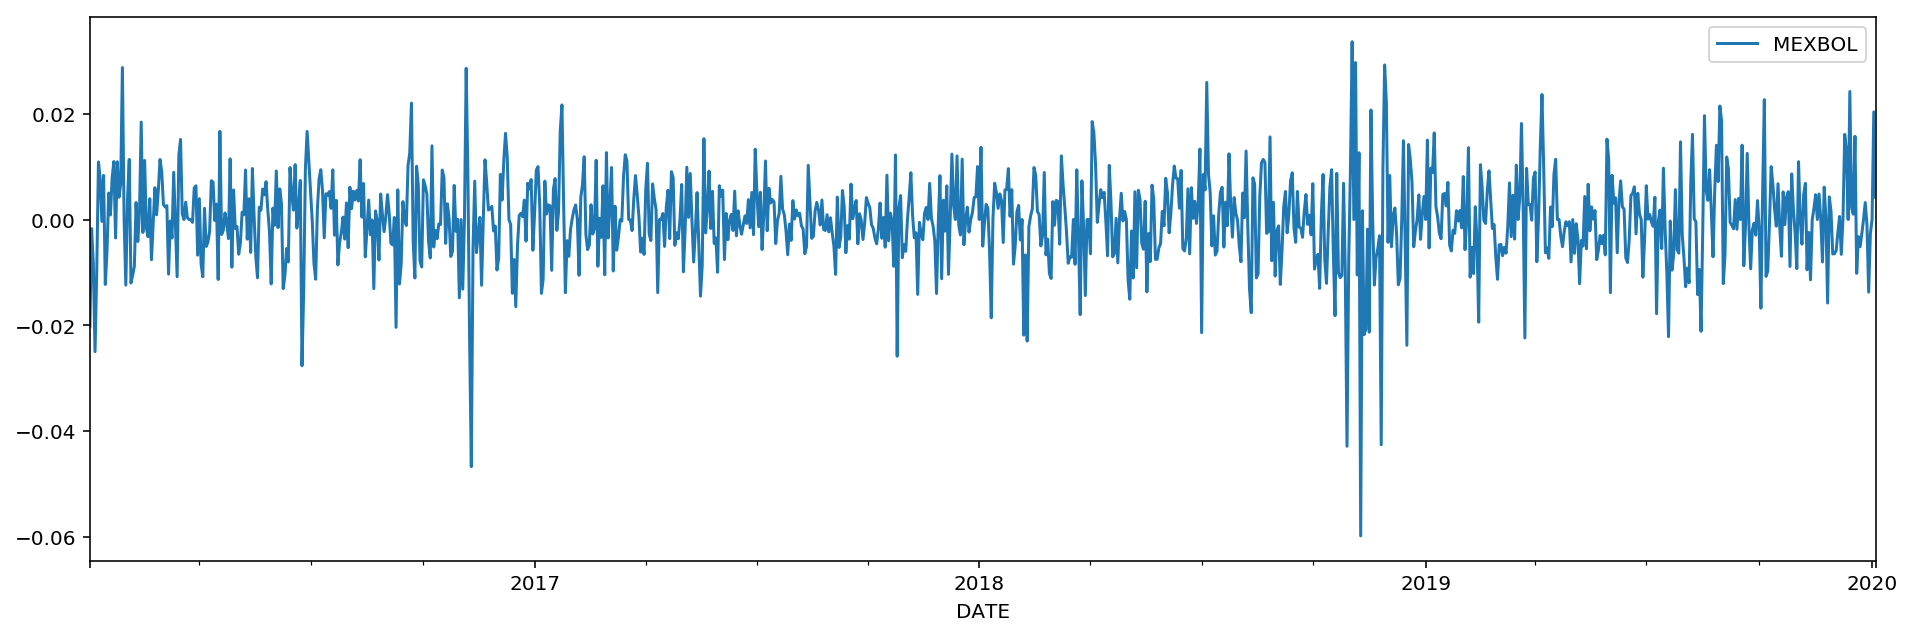

In [41]:
rendimientos = np.log(dataset[["MEXBOL"]]).diff().dropna()
rendimientos.plot(figsize=(16,5))

In [25]:
print("Varianza =>\n\n{}\n".format(rendimientos.var(ddof=1)))

Varianza =>

MEXBOL    0.000071
dtype: float64



In [36]:
seed(122448)

lamb = np.abs(randn(1))
sigma_init = rendimientos.var(ddof=1).item()/252

print("Función Garch => {}\n"
      .format(LGarch(
          lamb,
          (rendimientos.var(ddof=1).item()/252),
          rendimientos)
             )
     )

Función Garch => -4254388.244439724



In [37]:
# x0 (gama, alfa y beta)
x0 = np.array([lamb])
L_part = lambda x0: LGarch(*x0, sigma_init, rendimientos)

def cons(x):
    return x[0]  
    
# restriccion de no negativos
bounds = [
    (0, None)   #lamb no puede ser negativo
]

# Minimizar el negativo
f_min = minimize(L_part, x0, constraints={"type":"ineq","fun":cons}, bounds=bounds)

lamb_garch = f_min.x[0]

print("Minimizando =>\n\n{}\n".format(f_min))
print("x0 (gama, alfa y beta optimizados) => {}\n".format(lamb_garch))

/Users/sergio.delacruz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/Users/sergio.delacruz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log


Minimizando =>

     fun: -4355.826078781174
     jac: array([-0.00170898])
 message: 'Optimization terminated successfully.'
    nfev: 27
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.90886247])

x0 (gama, alfa y beta optimizados) => 0.9088624702595818



In [38]:
temp_sigma = sigma_init 
predictions = []

for i in range(len(rendimientos)):
    temp_sigma = (1-lamb_garch) * rendimientos.iloc[i].item()**2 + lamb_garch*temp_sigma
    predictions.append(temp_sigma)

temp_num = 20
print("Primeras {} predicciones =>\n\n{} ...\n".format(temp_num, predictions[:temp_num]))

Primeras 20 predicciones =>

[3.7826626544805885e-05, 3.464619427042817e-05, 3.787598911246906e-05, 9.141425795205574e-05, 9.182088463354496e-05, 9.429167774170215e-05, 9.114274567469077e-05, 8.284677861339186e-05, 8.165482698424838e-05, 8.797522899627544e-05, 8.319959944102531e-05, 7.791619569619752e-05, 7.088269940437776e-05, 7.005891189238959e-05, 7.465798292589815e-05, 6.896321001255248e-05, 7.35761198000042e-05, 6.84967202311781e-05, 6.634660075382153e-05, 0.00013578237279588976] ...



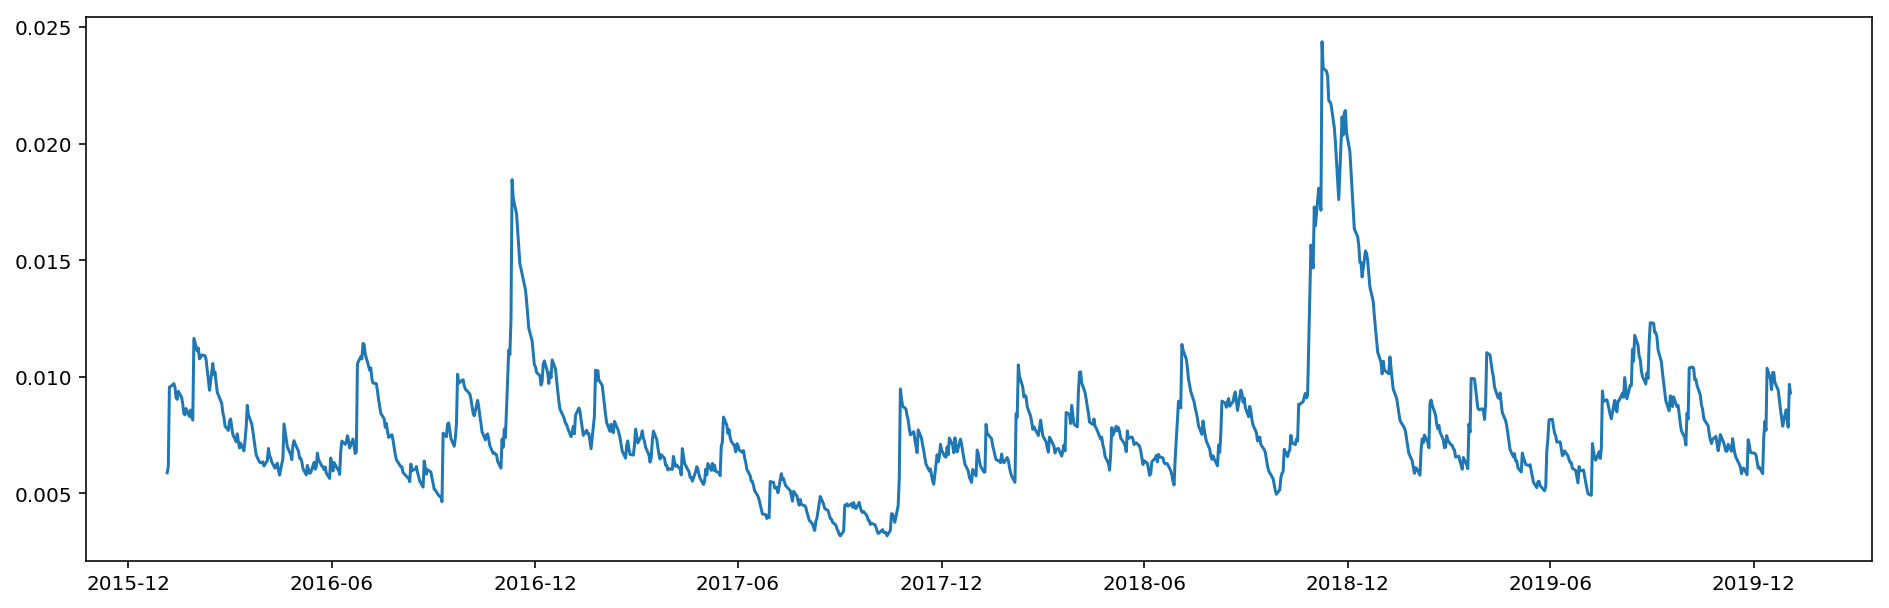

In [112]:
plt.subplots(figsize=(16,5))
plt.plot(rendimientos.index[1:], np.sqrt(predictions)[1:])

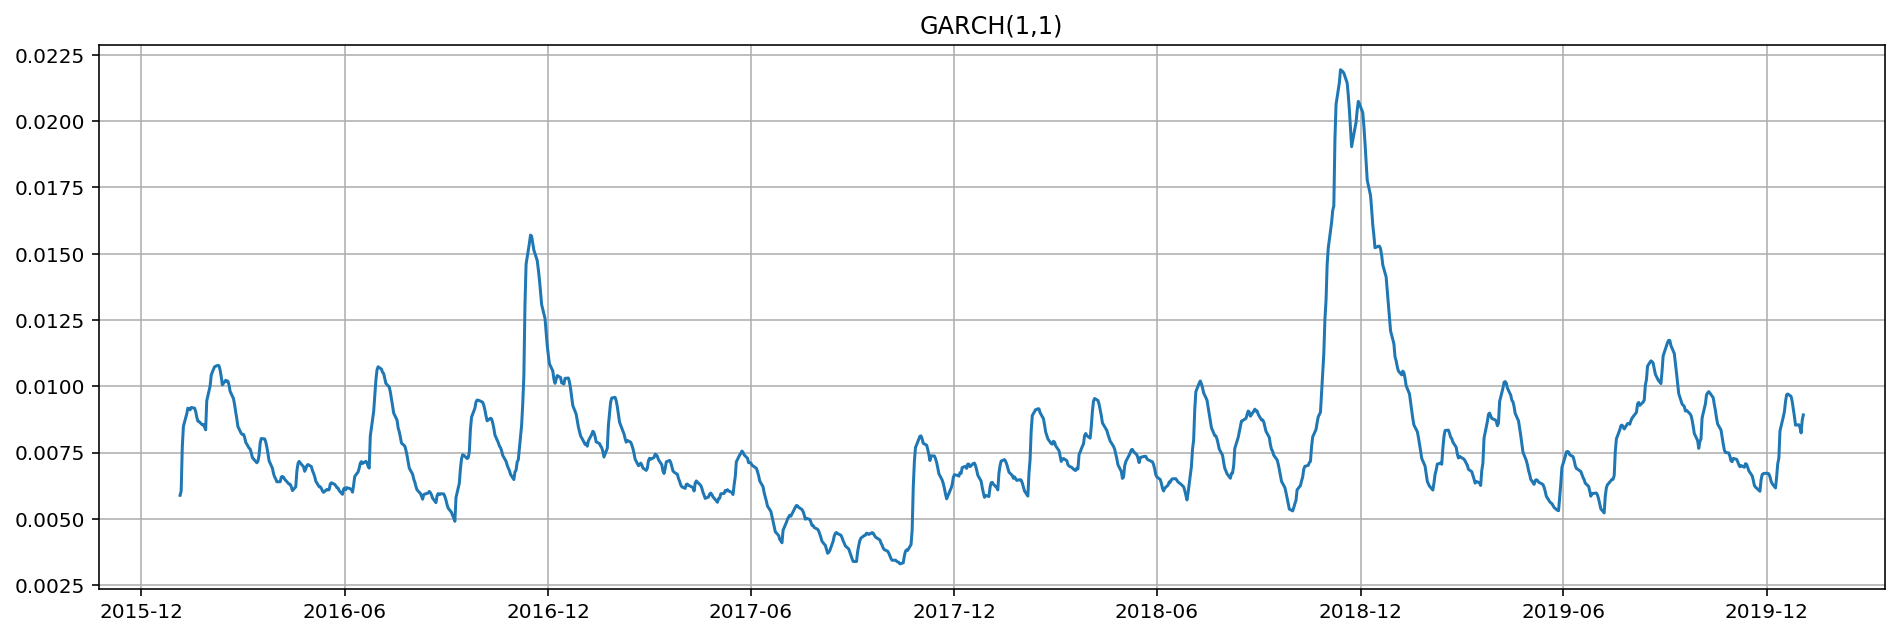

In [48]:
plt.subplots(figsize=(16,5))
plt.title("GARCH(1,1)")
plt.plot(rendimientos.index[1:], pd.Series(np.sqrt(predictions)[1:]).ewm(2).mean());
plt.grid()